In [1]:
from collections import defaultdict
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from bgspy.models import BGSModel
from bgspy.genome import Genome
from bgspy.data import GenomicBins, GenomicBinnedData


2022-09-19 19:29:43.897546: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/home/vsb/projects/bprime/bgspy/data.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdm


In [2]:
plt.style.use('./buffalo.mplstyle')
plt.rcParams['figure.figsize'] = [8, 3.5]
plt.rcParams['figure.dpi'] = 200

In [3]:
def get_gwascat_sites(df, append_chr=True, chrom_col='CHR_ID', pos_col='CHR_POS'):
    sites = defaultdict(list)
    bad = []
    ignored = 0
    prefix = 'chr' if append_chr else ''
    for chr, pos in zip(df[chrom_col].tolist(), df[pos_col].tolist()):
        chr = str(chr)
        if isinstance(pos, float) and np.isnan(pos):
            ignored += 1
            continue
        try:
            if isinstance(pos, str) and ';' in pos:
                for c, p in zip(chr.split(';'), pos.split(';')):
                    sites[prefix + c].append(int(p))
                continue
            sites[prefix + chr].append(int(pos))
        except ValueError:
            bad.append((prefix + chr, pos))
    if len(bad):
        print(f"{len(bad)} sites could not be parsed ({ignored} nan sites ignored)!")
    return sites, bad


def count_in_bins(sites, bins):
    """
    Count the number of sites (a chromdict) that fall in the bins.
    This is an inefficient alogirithm — O(nm).
    """
    assert isinstance(sites, dict), "sites must be a chrom dict"
    counts = np.zeros(len(bins))
    for i, (chrom, start, end) in enumerate(bins):
        for pos in sites[chrom]:
            if start <= pos <= end:
                counts[i] += 1
    return counts
            

## Load Genome Data and B Models

In [4]:
autos = [f'chr{i}' for i in range(1, 23)]
g = Genome('hg38', seqlens_file="../data/annotation/hg38_seqlens.tsv", chroms=autos)

In [5]:
merged_pkl = '../data/bmaps/bgspy/bmap_hg38_6x5grid_10000step_10000N_cds_utrs_phastcons_merged.pkl'
merged_m = BGSModel.load(merged_pkl)

In [6]:
merged_m.w, merged_m.t

(array([1.00000000e-11, 6.30957344e-11, 3.98107171e-10, 2.51188643e-09,
        1.58489319e-08, 1.00000000e-07]),
 array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01]))

### GWAS Catalog

In [7]:
gwcat = pd.read_csv('../data/annotation/gwas_catalog.tsv', sep='\t')

/tmp/ipykernel_59156/642341771.py:1: DtypeWarning: Columns (9,12,23) have mixed types. Specify dtype option on import or set low_memory=False.
  gwcat = pd.read_csv('../data/annotation/gwas_catalog.tsv', sep='\t')


In [8]:
gwas_hits, _ = get_gwascat_sites(gwcat)

268 sites could not be parsed (18885 nan sites ignored)!


In [34]:
hits_by_chrom = {c: len(v)/g.seqlens[c] for c, v in gwas_hits.items() if c in g.seqlens}

sorted(hits_by_chrom.items(), key=lambda x: x[1])

[('chr21', 6.675232572874197e-05),
 ('chr13', 7.024917769813679e-05),
 ('chr18', 9.73706624035586e-05),
 ('chr4', 9.925107991867394e-05),
 ('chr14', 0.00010134177140595957),
 ('chr9', 0.00011192623776238511),
 ('chr5', 0.0001155844509889235),
 ('chr7', 0.00011769359241980969),
 ('chr3', 0.0001184696224084373),
 ('chr10', 0.00012378414884555848),
 ('chr22', 0.0001266468717632338),
 ('chr2', 0.0001353669527644564),
 ('chr8', 0.0001369449276070088),
 ('chr1', 0.00014109698282858515),
 ('chr15', 0.0001466793371729395),
 ('chr12', 0.00014906737151140276),
 ('chr16', 0.00017519692219289604),
 ('chr20', 0.0001757490324919554),
 ('chr6', 0.00019305530282403053),
 ('chr17', 0.00021102017776405114),
 ('chr11', 0.00023849882040873004),
 ('chr19', 0.00030862735871073295)]

In [9]:
def hscore(logBp, logB):
    """
    Some measure of the HRI, e.g. B'-B.
    """
    return (np.exp(logBp) - np.exp(logB))

### Bin the Data

In [10]:
gd = GenomicBinnedData(g.seqlens, 1e6)
bins = gd.flat_bins()

In [11]:
merged_b = gd.bin_Bs(merged_m.BScores)
merged_bp = gd.bin_Bs(merged_m.BpScores)

In [12]:
#gwas_hits, _ = get_gwascat_sites(bd, chrom_col='Chr', pos_col='Position')


In [13]:
cnts = count_in_bins(gwas_hits, bins)

(array([132.,  89., 173., 226., 345., 385., 446., 519., 545.,  25.]),
 array([3.44469884e-11, 7.62975832e-03, 1.52595166e-02, 2.28892749e-02,
        3.05190332e-02, 3.81487915e-02, 4.57785498e-02, 5.34083081e-02,
        6.10380664e-02, 6.86678246e-02, 7.62975829e-02]),
 <BarContainer object of 10 artists>)

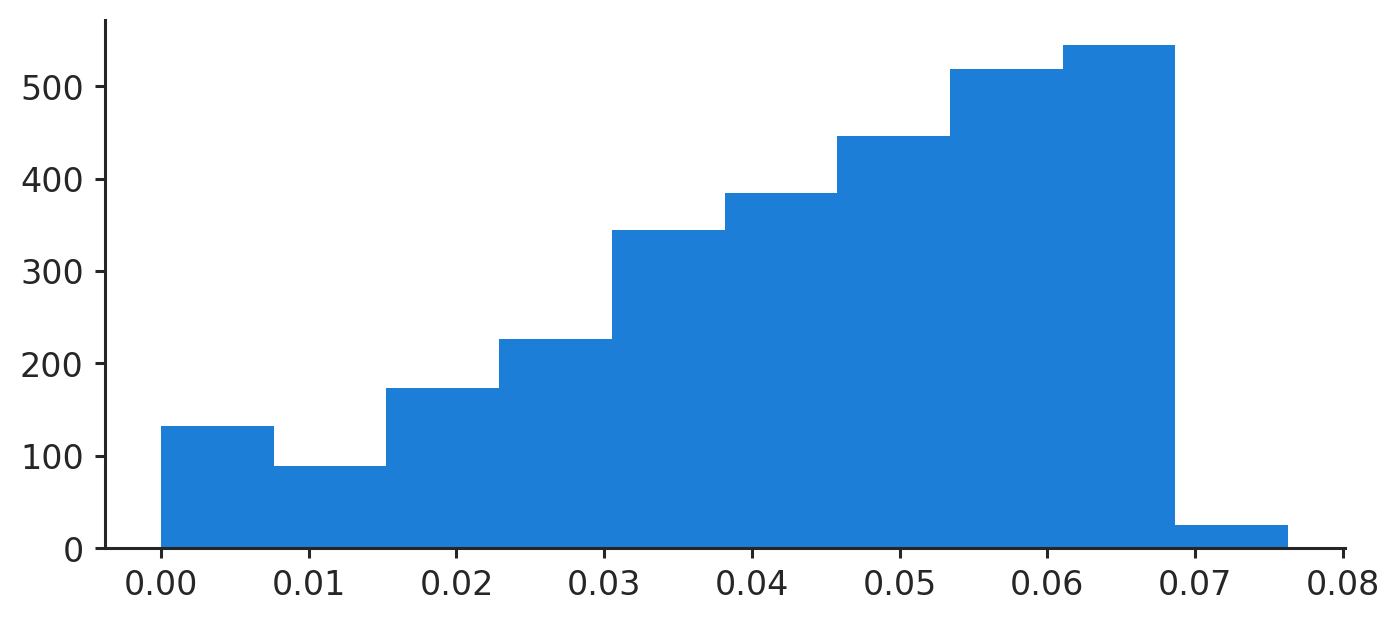

In [35]:
plt.hist(hri)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial


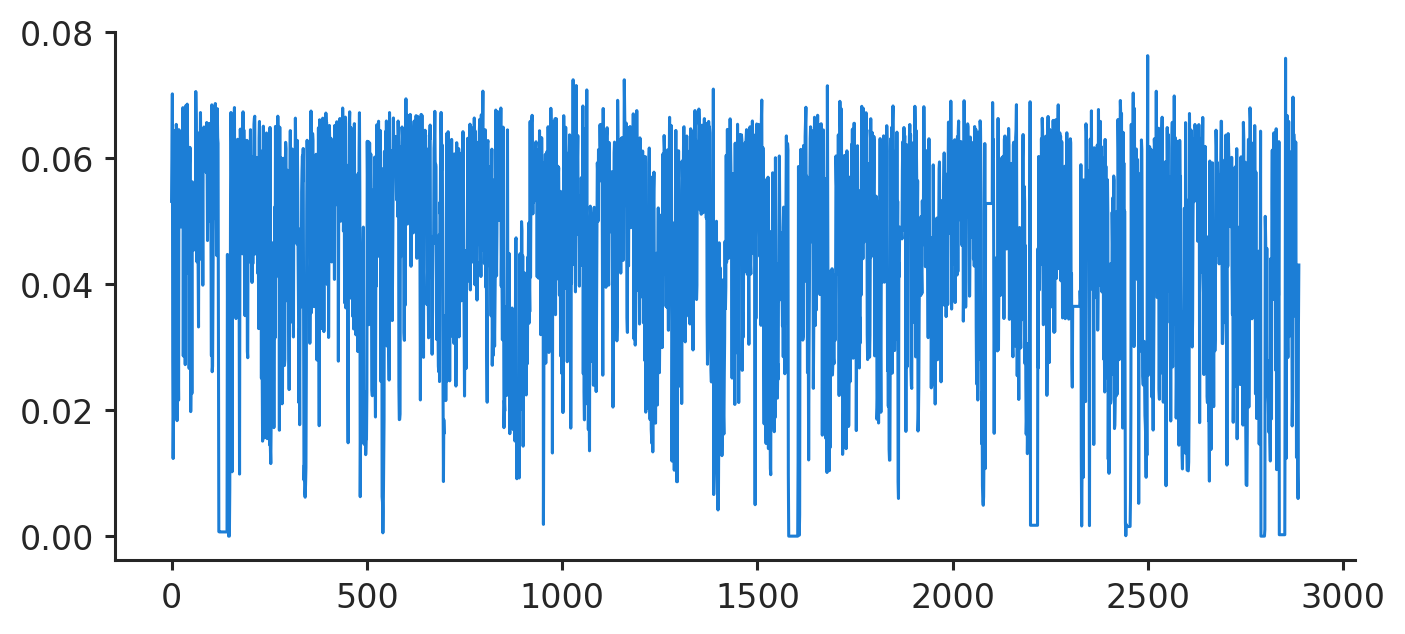

In [14]:

hri = (merged_bp[:, 4, 1, 0] - merged_b[:, 4, 1, 0])
hri = (np.exp(merged_bp[:, 4, 1, 0]) - np.exp(merged_b[:, 4, 1, 0])) 
#hri = np.exp(merged_bp[:, 4, 3])
hri[hri <= 0] = np.nan
cntsx = cnts[~np.isnan(hri)]
hrix = hri[~np.isnan(hri)]
plt.plot(hri)

In [15]:
cnts.shape, hri.shape

((2887,), (2887,))

[]

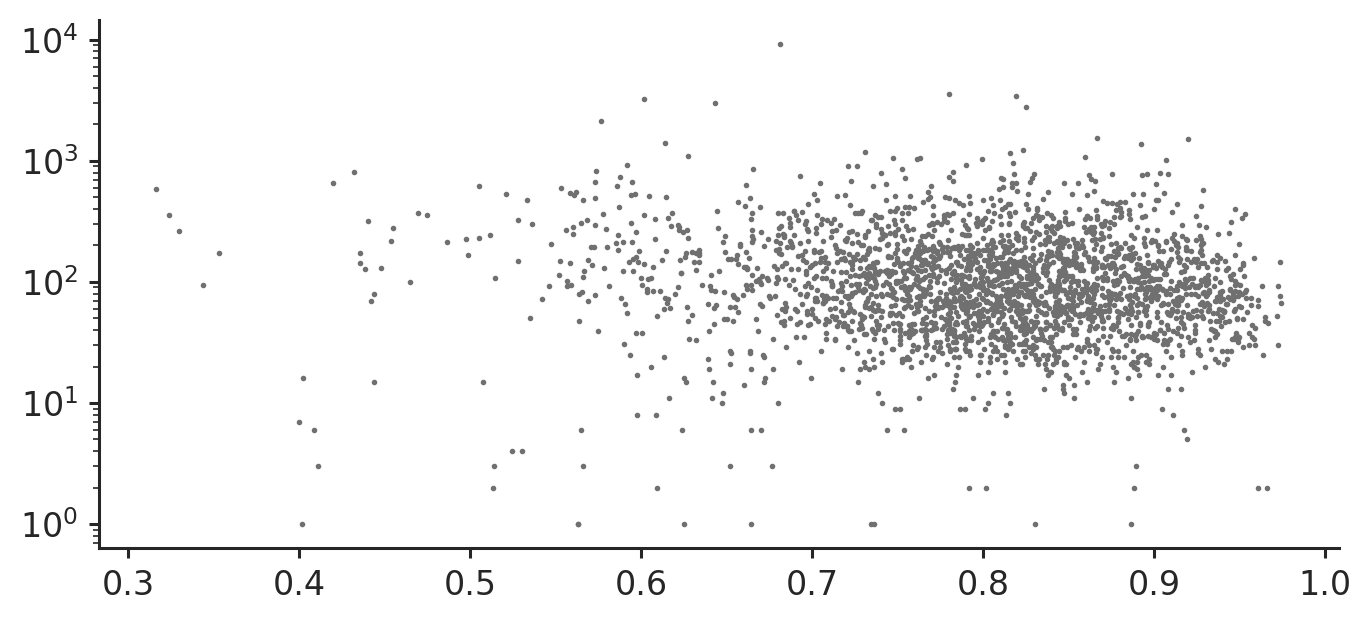

In [16]:
Bt = np.exp(merged_b[:, 4, 3, 0])
Btx = Bt[~np.isnan(hri)]
plt.scatter(Bt, cnts, s=1, c='0.44')
lowess = sm.nonparametric.lowess
#f = lowess(cnts, Bt)
#plt.plot(*f.T, c='r')
plt.semilogy()

Text(0.5, 0, "h-score (h = B'-B)")

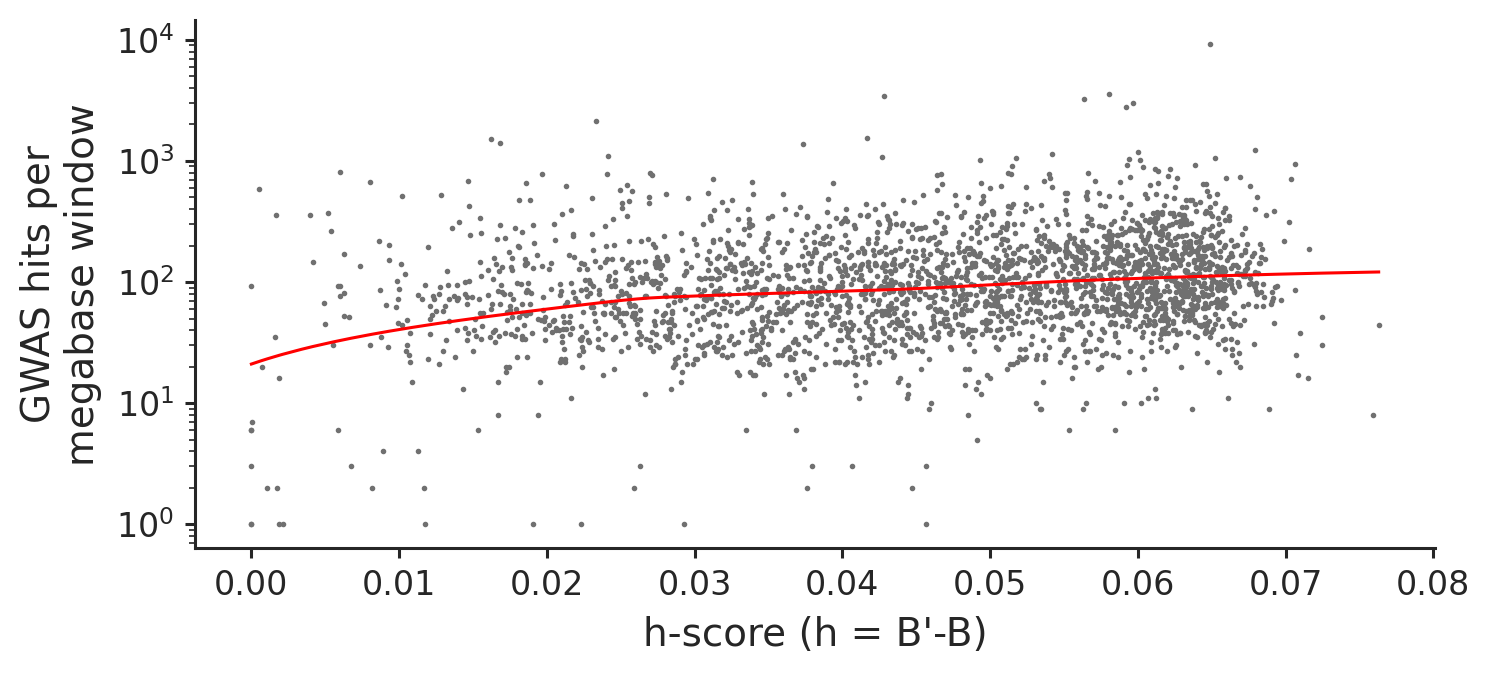

In [22]:
plt.scatter(hrix, cntsx, s=1, c='0.44')
lowess = sm.nonparametric.lowess
f = lowess(cntsx, hrix)
plt.plot(*f.T, c='r')
plt.semilogy()
plt.ylabel('GWAS hits per\nmegabase window')
plt.xlabel("h-score (h = B'-B)")

In [21]:
X = sm.add_constant(Btx)
res = sm.OLS(np.log10(cntsx+1e-6), X).fit()

print(res.summary())
res.pvalues

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     13.30
Date:                Mon, 19 Sep 2022   Prob (F-statistic):           0.000271
Time:                        19:42:03   Log-Likelihood:                -6004.4
No. Observations:                2885   AIC:                         1.201e+04
Df Residuals:                    2883   BIC:                         1.202e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4578      0.282      1.623      0.1

array([0.10467146, 0.00027071])

In [19]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     13.30
Date:                Mon, 19 Sep 2022   Prob (F-statistic):           0.000271
Time:                        19:40:45   Log-Likelihood:                -6004.4
No. Observations:                2885   AIC:                         1.201e+04
Df Residuals:                    2883   BIC:                         1.202e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4578      0.282      1.623      0.105      -0.095       1.011
x1             1.2831      0.352      3.646      0.000       0.593       1.973
==============================================================================
Omnibus:                     1981.924   Durbin-Watson:                   0.324
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17974.712
Skew:                          -3.374   Prob(JB):                         0.00
Kurtosis:                      13.197   Cond. No.                         15.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
gwcat.shape

(421875, 34)

In [660]:
res

In [656]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     7.874
Date:                Mon, 19 Sep 2022   Prob (F-statistic):            0.00505
Time:                        17:01:29   Log-Likelihood:                -17445.
No. Observations:                2496   AIC:                         3.489e+04
Df Residuals:                    2494   BIC:                         3.490e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        140.8076      6.124     22.994      0.000     128.800     152.816
x1            68.6122     24.452      2.806      0.005      20.664     116.560
==============================================================================
Omnibus:                     5503.715   Durbin-Watson:                   1.775
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         38713617.217
Skew:                          19.540   Prob(JB):                         0.00
Kurtosis:                     611.867   Cond. No.                         4.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [645]:
stats.pearsonr(hri[:, 0], cnts)

(0.056098999067476424, 0.00505498207312836)

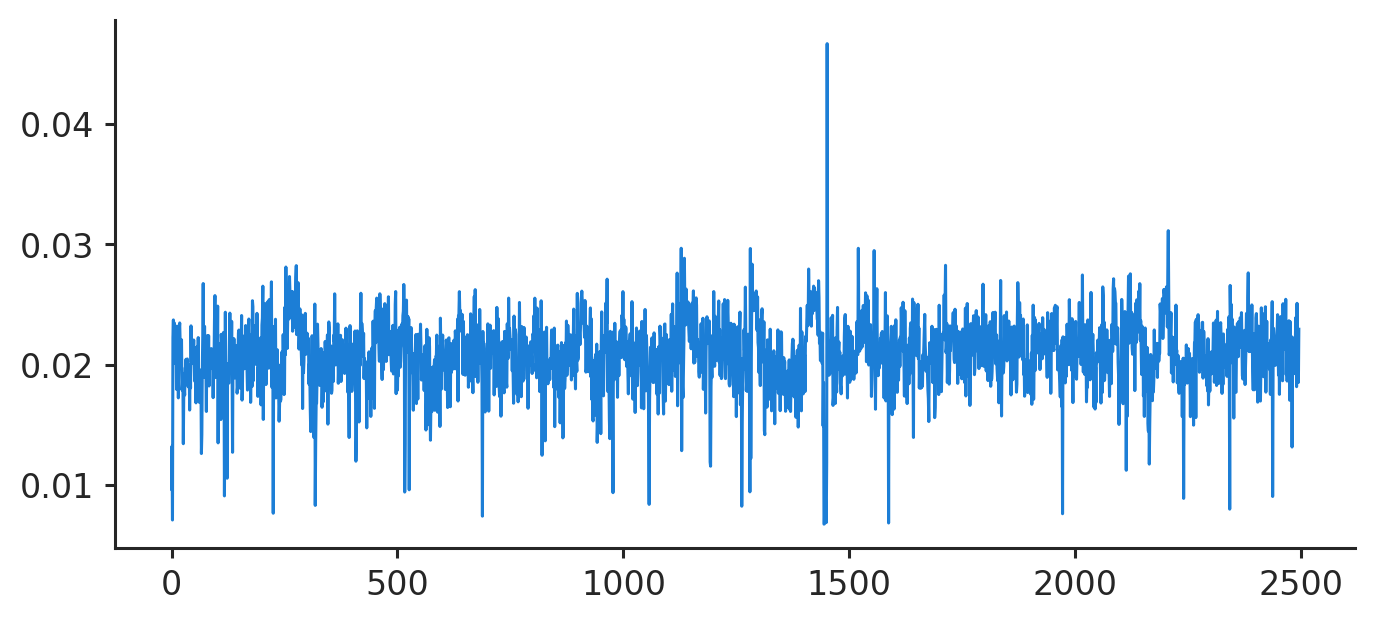

In [622]:
plt.plot(hri)

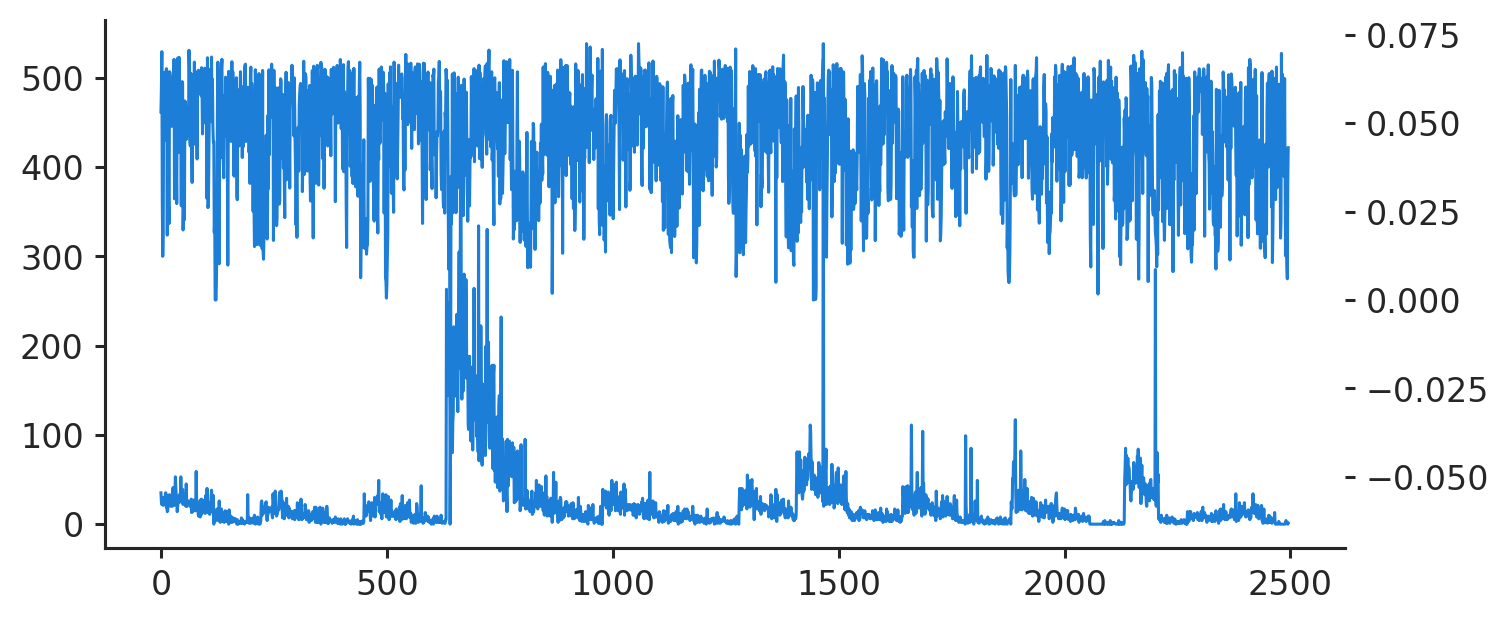

In [578]:
fig, ax = plt.subplots()
ax.plot(cnts)
ax2 = ax.twinx()
ax2.plot(hri)